In [40]:
import sys
import pandas as pd
import numpy as np

sys.path.append('..')

In [41]:
import rbf_functions

In [42]:
rbf = rbf_functions.squared_exponential_rbf.__name__
output_dir = f"../output/{rbf}/"

In [43]:
archives_by_nfe = pd.read_csv(output_dir + '10_hypervolume.csv')
print(f"rows: {archives_by_nfe['0'].count()}")

nfes = archives_by_nfe["Unnamed: 0"].values
u_nfes = np.unique(nfes)
selected_nfe = u_nfes[0::5]
archives_by_nfe = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe )]

print(f"Selected: {len(selected_nfe)} nfe generations:")
print(selected_nfe)
print(f"rows: {archives_by_nfe['0'].count()}")
archives_by_nfe.head()


rows: 32768
Selected: 30 nfe generations:
[  100   600  1100  1600  2100  2600  3100  3600  4100  4600  5100  5600
  6100  6600  7100  7600  8100  8600  9100  9600 11519 15859 20199 24539
 28879 33219 37559 41899 46239 50579]
rows: 6749


,Unnamed: 0,Unnamed: 1,0,1,2,3,4,5
0,100,0,44.992592,0.550813,0.433861,0.318733,0.084848,1.0
1,100,1,45.509716,0.202915,0.163180,0.148392,0.081956,1.0
2,100,2,46.095984,0.295024,0.333018,0.155382,0.085453,1.0
3,100,3,30.257661,0.178661,0.167211,0.185919,0.081523,1.0
4,100,4,60.084563,0.545179,0.371366,0.321381,0.086085,1.0


we need to transform the dataframe back into platypus solution instances.

We need to have a collection of solutions for each generation


In [44]:
from platypus import Solution, Problem

n_rbfs = 4
n_objs = 6
n_vars = n_rbfs * 8 

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomic power plant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MAXIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation

archives = {}
for nfe, generation in archives_by_nfe.groupby("Unnamed: 0"):
    # we slice from 2, getting rid of the first two columns 
    # which contain the NFE and ID of each solution
    archive = []
    for i, row in generation.iloc[:, 2::].iterrows():
        solution = Solution(problem)
        solution.objectives = row
        archive.append(solution)
    archives[nfe] = archive
        


in this case our reference set is the final set of solutions (only a single seed). So let's load this data as well and turn it into a set of solution in the same way as we did with the archives.

In [45]:
data = pd.read_csv(output_dir + '10_solution.csv')

ref_set = []
for i, row in data.iterrows():
    solution = Solution(problem)
    solution.objectives = row
    ref_set.append(solution)


In [46]:
data

,hydropower,atomicpowerplant,baltimore,chester,environment,recreation
0,73.154201,0.778500,0.640140,0.743475,0.086968,1.0
1,68.964924,0.683074,0.833056,0.702342,0.088915,1.0
2,61.437643,0.951015,0.312643,0.314327,0.078566,1.0
3,63.605227,0.866501,0.450539,0.646095,0.077170,1.0
4,75.002407,0.913329,0.679578,0.797816,0.087382,1.0
...,...,...,...,...,...,...
519,51.786214,0.916771,0.747805,0.549118,0.080422,1.0
520,74.522549,0.787565,0.100560,0.278010,0.077419,1.0
521,65.774205,0.714676,0.491076,0.900652,0.081092,1.0
522,48.477740,0.896642,0.452190,0.751339,0.068596,1.0


In [47]:
from platypus import Hypervolume

hv = Hypervolume(reference_set=ref_set)

nfes = []
hvs = []
for nfe, archive in archives.items():
    nfes.append(nfe)
    hvs.append(hv.calculate(archive))

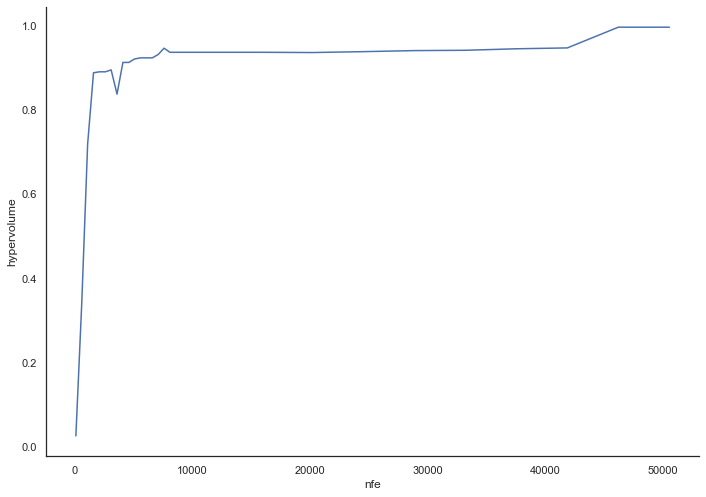

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")

fig, ax = plt.subplots()

ax.plot(nfes, hvs)
ax.set_xlabel('nfe')
ax.set_ylabel('hypervolume')
sns.despine()

plt.show()

In [60]:
e_progress = pd.read_csv(output_dir + '10_convergence.csv')
e_progress

,Unnamed: 0,nfe,improvements
0,0,100,16
1,1,200,23
2,2,300,39
3,3,400,58
4,4,500,74
...,...,...,...
141,141,47107,2731
142,142,47975,2775
143,143,48843,2818
144,144,49711,2859


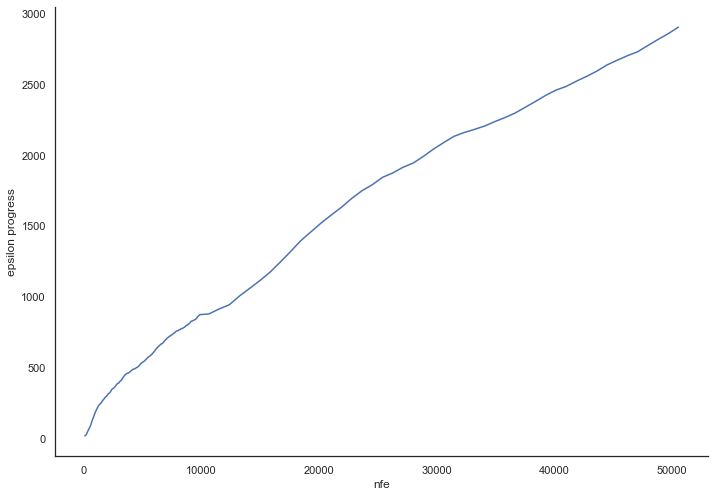

In [67]:
fig, ax = plt.subplots()
ax.plot(e_progress.nfe, e_progress.improvements)
ax.set_xlabel('nfe')
ax.set_ylabel('epsilon progress')
sns.despine()

plt.show()

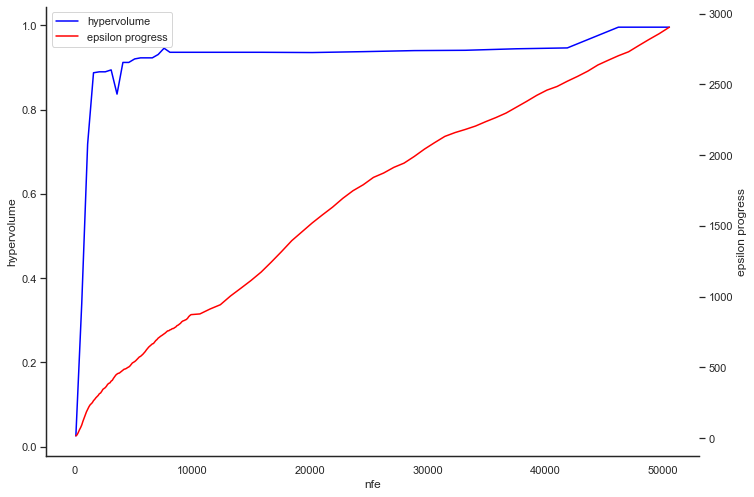

In [89]:
sns.set_style("white")

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(nfes, hvs, color= "blue", label="hypervolume")
ax2.plot(e_progress.nfe, e_progress.improvements, color='red', label="epsilon progress")
ax.set_xlabel('nfe')
ax.set_ylabel('hypervolume')
ax2.set_ylabel('epsilon progress')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
sns.despine()

plt.show()